## Exotic Options and Car Loan Models

In [2]:

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

In [30]:
def StockPrices(S0, r, sd, T, paths, steps):
    
    dt = T/steps
    
    # Generate stochastic process and its antithetic paths
    Z = np.random.normal(0, 1, paths//2 * steps).reshape((paths//2, steps))
    Z_inv = -Z
    
    dWt = math.sqrt(dt) * Z
    dWt_inv = math.sqrt(dt) * Z_inv
    
    # bind the normal and antithetic Wt
    dWt = np.concatenate((dWt, dWt_inv), axis=0)
    
    St = np.zeros((paths, steps + 1))
    St[:, 0] = S0
    
    for i in range (1, steps + 1):
        St[:, i] = St[:, i - 1]*np.exp((r - 1/2*np.power(sd, 2))*dt + sd*dWt[:, i - 1])
    
    return St[:, 1:]

In [31]:
def LookBackOption(S0, K, r, sd, T, paths, Type):
    
    # use daily frequency
    steps = 252
    St = StockPrices(S0, r, sd, T, paths, steps)
    
    # find the maximum and minimum stock price incurred for each path
    St_max = St.max(axis = 1)
    St_min = St.min(axis = 1)
    
    # find the lookback option value
    if Type == "call":
        option_value = np.exp(-r*T) * np.mean(np.maximum(St_max - K, 0))
    elif Type == "put":
        option_value = np.exp(-r*T) * np.mean(np.maximum(K - St_min, 0))
        
    return option_value

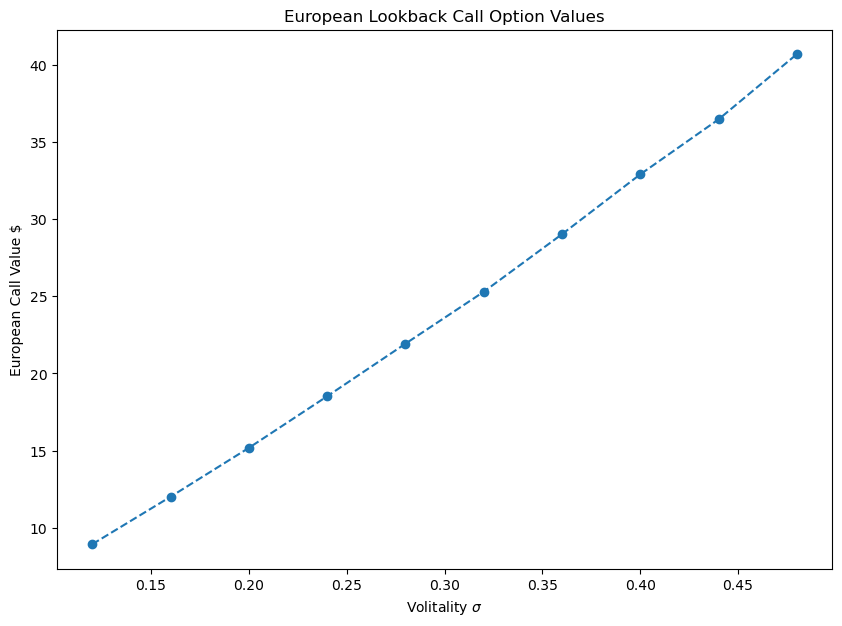

In [34]:
np.random.seed(7)
r = 0.03
paths = 10000
K = 100
S0 = 98
T = 1
sd = np.arange(0.12, 0.49, 0.04)

call_value = [LookBackOption(S0, K, r, i, T, paths, "call") for i in sd]
put_value = [LookBackOption(S0, K, r, i, T, paths, "put") for i in sd]
plt.figure(figsize=(10, 7))
plt.plot(sd, call_value,  linestyle='--', 
         marker='o')

plt.xlabel('Volitality $\sigma$')
plt.ylabel('European Call Value $')
plt.title('European Lookback Call Option Values')
plt.show()

## Jump Diffusion Process

In [38]:
def loanCollateral_Vt(V0, mu, sigma, gamma, lambda1, T, paths):
    
    dt = 1/12
    steps = T * 12

    # Generate stochastic process
    Z = np.random.normal(0, 1, paths * steps).reshape((paths, steps))
    dWt = math.sqrt(dt) * Z

    # Initialize Vt process
    Vt = np.zeros((paths, steps + 1))
    Vt[:, 0] = V0

    # Build Vt Process
    for i in range (1, steps + 1):
        Vt[:, i] = (Vt[:, i - 1] * np.exp((mu - 1/2*np.power(sigma, 2)) * dt + sigma * dWt[:, i - 1]) 
                     * (1 + gamma * np.random.poisson(lambda1*dt, paths)))   
        
    return Vt[:, 1:]

In [39]:
def loanBalance_Lt(L0, r0, T, lambda2, delta, t):
    
    # find monthly APR (r)
    R = r0 + delta*lambda2
    r = R/12
    
    # find monthly payment
    n = T * 12
    PMT = (L0*r)/(1 - (1/(1+r)**n))
    
    # Find the loan value given time t
    a = PMT/r
    b = PMT/(r*(1 + r)**n)
    c = (1 + r)
    Lt = np.clip(a - b*c**(12*t), a_max = None, a_min = 0)
    
    return Lt[1:]

def recoveryRate_qt(alpha, eps, T, t):
    beta = (eps - alpha)/T
    qt = alpha + beta*t 
    return qt[1:]

def stopTime_Q(Vt, eps, paths, T):
    
    dt = 1/12
    t = np.arange(0, T + 0.01, 1/12)
    
    # find loan balance and recovery rate over time
    Lt = loanBalance_Lt(L0, r0, T, lambda2, delta, t)
    qt = recoveryRate_qt(alpha, eps, T, t)
    
    # find all of the time steps that the borrow are likely default, set the value of default_time at time step to 1
    residual_collateral = np.tile(Lt*qt, paths).reshape((paths, 12 * T))
    default_time = np.where(Vt - residual_collateral  <= 0, 1, 0)
    
    # Find stopping time Qt
    Q = np.argmax(default_time, axis = 1) 
    
    # Set all paths that has no default to the largest value of index
    no_default = np.where(np.sum(default_time, axis = 1) == 0)
    Q[no_default] = 5000
    
    return Q

def stopTime_S(lambda2, paths, T):
    
    # Generate a matrix of poisson process
    dt = 1/12
    Nt = np.clip(np.random.poisson(lambda2*dt, (paths, T*12)), 
                 a_max = 1,
                 a_min = 0)
    
    S = np.argmax(Nt, axis = 1) 
    # Set all paths that has no default to the largest value of index
    no_default = np.where(np.sum(Nt, axis = 1) == 0)
    S[no_default] = 5000
    
    return S 

def estimated_default_time(Q, S):
    
    # find which one (Q, S) is exercised earlier
    qs = np.where(Q - S <= 0, 1, 0)
    
    # set the paths where there is no default to 5000
    no_default = np.where(Q + S == 5000*2)
    qs[no_default] = 5000
    
    return np.minimum(Q, S), qs

In [40]:
def loanModel(V0, mu, sigma, gamma, lambda1,
                       T, paths, L0, r0, lambda2, delta, eps):
    dt = 1/12
    t = np.arange(0, T + 0.01, 1/12)
    
    # find loan collateral value
    Vt = loanCollateral_Vt(V0, mu, sigma, gamma, lambda1, T, paths)
    
    # loan balance
    Lt = np.tile(loanBalance_Lt(L0, r0, T, lambda2, delta, t), paths).reshape((paths, 12 * T))
    
    # default time Q, S
    Q = stopTime_Q(Vt, eps, paths, T)
    S = stopTime_S(lambda2, paths, T)
    
    # optimal default time
    tau, qs = estimated_default_time(Q, S)
    
    # find which type of default occured
    default_q = np.where(qs == 1)
    default_s = np.where(qs == 0)
    no_default = np.where(qs == 5000)
    
    # find discount factor of each path
    df = np.exp(-r0*dt*tau) 

    # find payoff of the default option, based on conditions
    payoff = np.zeros(paths)
    payoff[default_q] = np.maximum(Lt[default_q, tau[default_q]] 
                                   - eps* Vt[default_q, tau[default_q]], 0)

    payoff[default_s] =  np.abs(Lt[default_s, tau[default_s]] 
                                - eps* Vt[default_s, tau[default_s]])

    payoff[no_default] = 0

    # discount the expected payoff and find the value of default option 
    option_value = np.mean(payoff*df)
    
    # find default intensity
    default_intensity =  1 - len(no_default[0])/paths
    
    # find expected stopping time
    expected_stoptime = np.mean(tau[np.where(tau != 5000)[0]]*dt)
    
    d = {'Option Value': round(option_value, 4),
        'Default Intensity': round(default_intensity, 4),
        'Expected Stop Time':round(expected_stoptime, 4)}
    
    return d

V0 = 20000
L0 = 22000
mu = -0.1
sigma = 0.2
gamma = -0.4
lambda1 = 0.2
T = 5
r0 = 0.02
delta = 0.25
lambda2 = 0.4
alpha = 0.7
eps = 0.95
paths = 50000
np.random.seed(7)

loan = pd.DataFrame.from_dict(loanModel(V0, mu, sigma, gamma, lambda1,
                       T, paths, L0, r0, lambda2, delta, eps), orient = 'index')
loan.columns = ['Values']
loan

,Values
Option Value,4751.3821
Default Intensity,0.9493
Expected Stop Time,1.1093


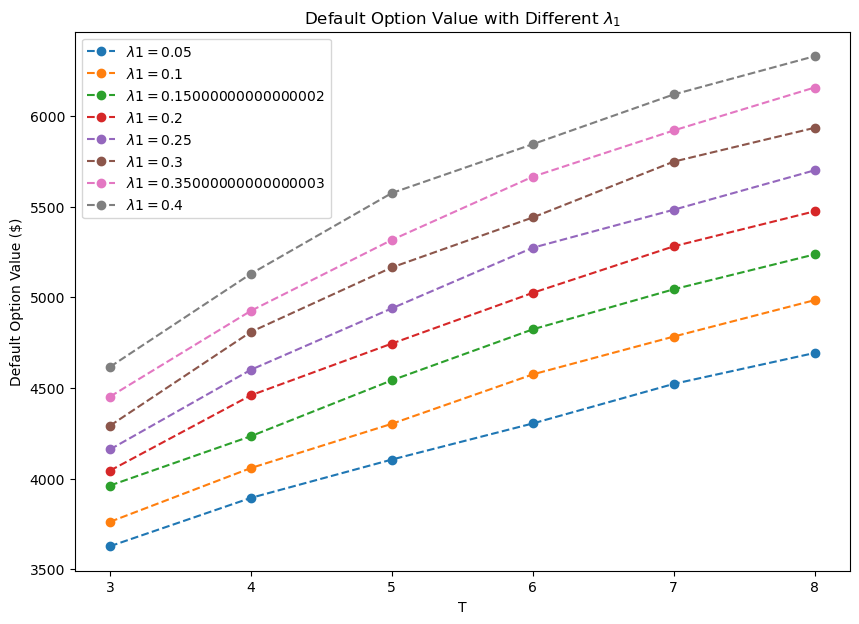

In [41]:
l1 = np.arange(0.05, 0.41, 0.05)
l2 = np.arange(0, 0.8, 0.1)
Time = np.arange(3, 9, 1)

lam2 = 0.4
optionValue_l1 = []
for lam1 in  l1:     
        for T in Time: 
            optionValue_l1.append(loanModel(V0, mu, sigma, gamma, lam1,
                       T, paths, L0, r0, lam2, delta, eps)['Option Value'])
optionValue_l1 = np.array(optionValue_l1).reshape((len(l1), len(Time)))
lam1 = 0.2
optionValue_l2 = []
for lam2 in  l2:     
        for T in Time: 
            optionValue_l2.append(loanModel(V0, mu, sigma, gamma, lam1,
                       T, paths, L0, r0, lam2, delta, eps)['Option Value'])
optionValue_l2 = np.array(optionValue_l2).reshape((len(l2), len(Time)))
plt.figure(figsize=(10, 7))
for i in range(len(optionValue_l1)):
    plt.plot(Time, optionValue_l1[i],  linestyle='--', 
             marker='o', label = '$\lambda1 = $' + str(l1[i]))

plt.legend()
plt.xlabel('T')
plt.ylabel('Default Option Value ($)')
plt.title('Default Option Value with Different $\lambda_1$')
plt.show()

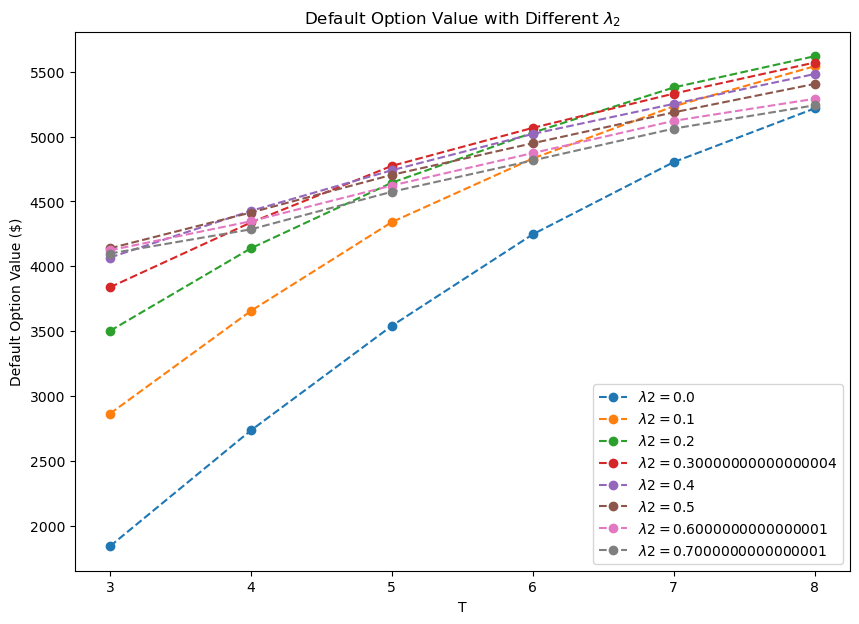

In [42]:
plt.figure(figsize=(10, 7))
for i in range(len(optionValue_l2)):
    plt.plot(Time, optionValue_l2[i],  linestyle='--', 
             marker='o', label = '$\lambda2 = $' + str(l2[i]))

plt.legend()
plt.xlabel('T')
plt.ylabel('Default Option Value ($)')
plt.title('Default Option Value with Different $\lambda_2$')
plt.show()

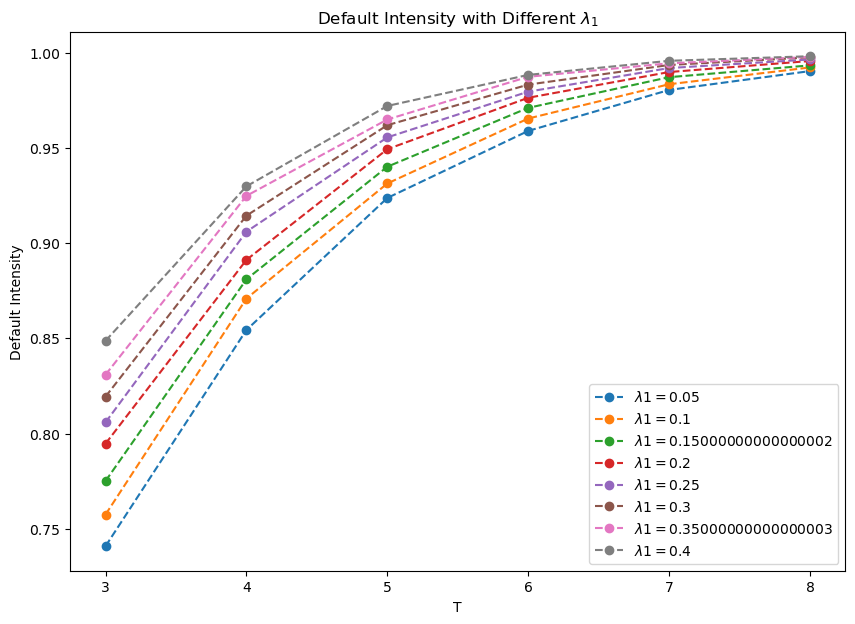

In [43]:
lam2 = 0.4
defaultIntensity_l1 = []
for lam1 in  l1:     
        for T in Time: 
            defaultIntensity_l1.append(loanModel(V0, mu, sigma, gamma, lam1,
                       T, paths, L0, r0, lam2, delta, eps)['Default Intensity'])
defaultIntensity_l1 = np.array(defaultIntensity_l1).reshape((len(l1), len(Time)))
lam1 = 0.2
defaultIntensity_l2 = []
for lam2 in  l2:     
        for T in Time: 
            defaultIntensity_l2.append(loanModel(V0, mu, sigma, gamma, lam1,
                       T, paths, L0, r0, lam2, delta, eps)['Default Intensity'])
defaultIntensity_l2 = np.array(defaultIntensity_l2).reshape((len(l2), len(Time)))
plt.figure(figsize=(10, 7))
for i in range(len(defaultIntensity_l1)):
    plt.plot(Time, defaultIntensity_l1[i],  linestyle='--', 
             marker='o', label = '$\lambda1 = $' + str(l1[i]))

plt.legend()
plt.xlabel('T')
plt.ylabel('Default Intensity')
plt.title('Default Intensity with Different $\lambda_1$')
plt.show()

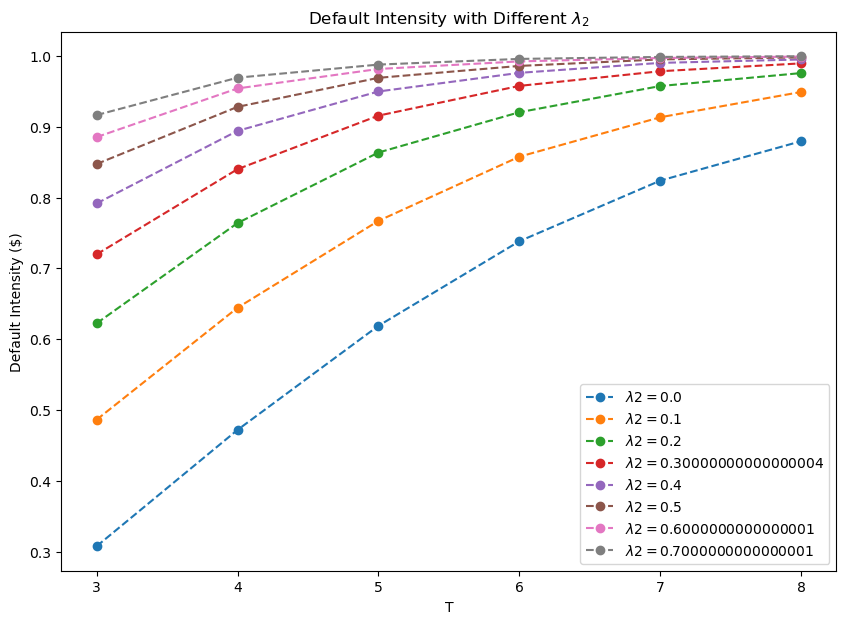

In [44]:
plt.figure(figsize=(10, 7))
for i in range(len(defaultIntensity_l2)):
    plt.plot(Time, defaultIntensity_l2[i],  linestyle='--', 
             marker='o', label = '$\lambda2 = $' + str(l2[i]))

plt.legend()
plt.xlabel('T')
plt.ylabel('Default Intensity ($)')
plt.title('Default Intensity with Different $\lambda_2$')
plt.show()

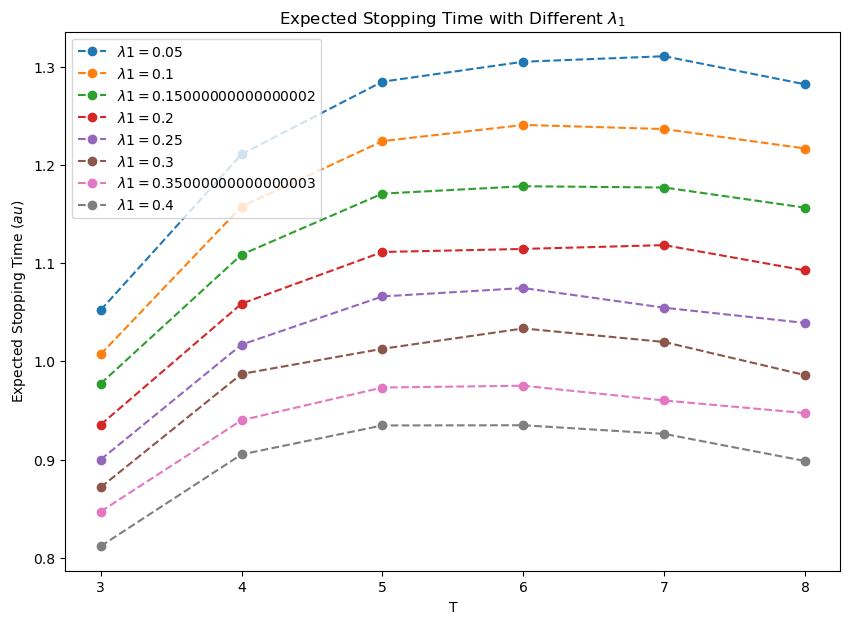

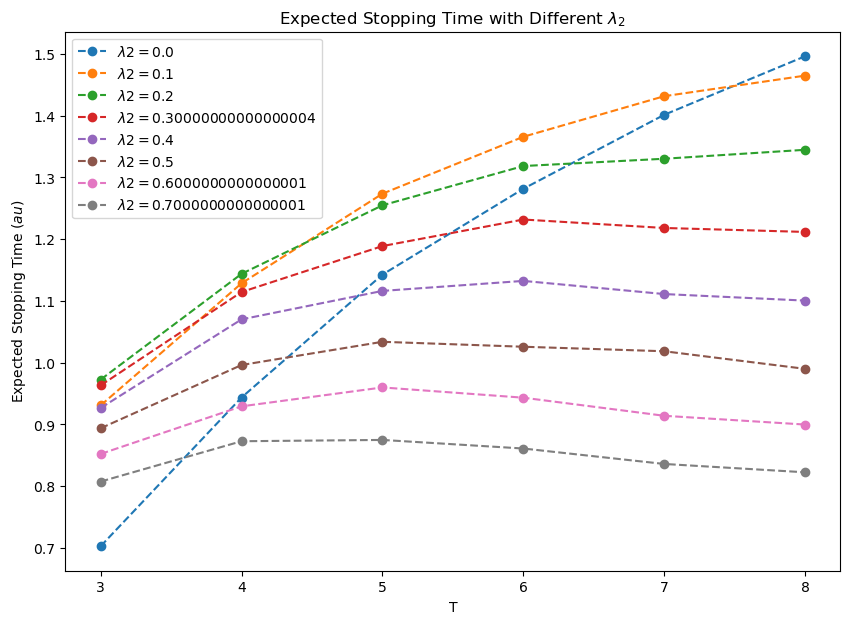

In [45]:
lam2 = 0.4
expectedStopTime_l1 = []
for lam1 in  l1:     
        for T in Time: 
            expectedStopTime_l1.append(loanModel(V0, mu, sigma, gamma, lam1,
                       T, paths, L0, r0, lam2, delta, eps)['Expected Stop Time'])
expectedStopTime_l1 = np.array(expectedStopTime_l1).reshape((len(l1), len(Time)))
lam1 = 0.2
expectedStopTime_l2 = []
for lam2 in  l2:     
        for T in Time: 
            expectedStopTime_l2.append(loanModel(V0, mu, sigma, gamma, lam1,
                       T, paths, L0, r0, lam2, delta, eps)['Expected Stop Time'])
expectedStopTime_l2 = np.array(expectedStopTime_l2).reshape((len(l2), len(Time)))
plt.figure(figsize=(10, 7))
for i in range(len(expectedStopTime_l1)):
    plt.plot(Time, expectedStopTime_l1[i],  linestyle='--', 
             marker='o', label = '$\lambda1 = $' + str(l1[i]))

plt.legend()
plt.xlabel('T')
plt.ylabel('Expected Stopping Time ($\tau$)')
plt.title('Expected Stopping Time with Different $\lambda_1$')
plt.show()

plt.figure(figsize=(10, 7))
for i in range(len(expectedStopTime_l2)):
    plt.plot(Time, expectedStopTime_l2[i],  linestyle='--', 
             marker='o', label = '$\lambda2 = $' + str(l2[i]))

plt.legend()
plt.xlabel('T')
plt.ylabel('Expected Stopping Time ($\tau$)')
plt.title('Expected Stopping Time with Different $\lambda_2$')
plt.show()